# PRIVATE DATASET INFERENCE NOTEBOOK - CLEAN VERSION

This notebook performs inference using trained models on the private dataset.

**Compatible with models trained in:**
- `training_private_DECEMBER_2024_baselines_CLEAN.ipynb`
- `training_private_DECEMBER_2024_venus_CLEAN.ipynb`

**FOCUS:** Private dataset ONLY - Individual tests clearly separated


## Setup and Imports


In [1]:
## Setup and Imports

import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import time
import pprint
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple, Optional
import sys

# PyTorch and related
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

# MONAI imports
import monai
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset
from monai.transforms import (
    LoadImaged, EnsureChannelFirstd, Compose
)

# Backend imports
from breast_segmentation.config.settings import config
from breast_segmentation.utils.seed import set_deterministic_mode, seed_worker, reseed
from breast_segmentation.data.dataset import PairedDataset, PairedDataLoader
from breast_segmentation.transforms.compose import Preprocess
from breast_segmentation.metrics.evaluation import compute_dice_score, compute_iou
from breast_segmentation.models.lightning_module import BreastSegmentationModel
from breast_segmentation.models.fusion_module import BreastFusionModel

from breast_segmentation.data.private_dataset import (
    PATIENT_INFO, get_filenames, get_train_val_test_dicts, PATIENTS_TO_EXCLUDE,
    filter_samples_sample_aware, filter_samples_to_exclude, get_samples_size
)

from breast_segmentation.metrics.losses import (
    CABFL, SurfaceLossBinary, AsymmetricUnifiedFocalLoss, 
    AsymmetricFocalLoss, AsymmetricFocalTverskyLoss, SoftDiceLoss
)

from breast_segmentation.inference.private_dataset_aware_test import (
    test_dataset_aware_ensemble,
    test_dataset_aware_no_patches,
    test_dataset_aware_fusion
)


import time 
import os

# Set precision and print config
torch.set_float32_matmul_precision('medium')
print_config()

# Pretty printer for results
pp = pprint.PrettyPrinter(indent=4)

# Converter function for PIL images
def convert_to_grayscale(image):
    """Convert PIL image to grayscale - replaces lambda for pickling compatibility."""
    return image.convert("L")


# Register loss classes for checkpoint loading
sys.modules['__main__'].CABFL = CABFL
sys.modules['__main__'].SurfaceLossBinary = SurfaceLossBinary
sys.modules['__main__'].AsymmetricUnifiedFocalLoss = AsymmetricUnifiedFocalLoss
sys.modules['__main__'].AsymmetricFocalLoss = AsymmetricFocalLoss
sys.modules['__main__'].AsymmetricFocalTverskyLoss = AsymmetricFocalTverskyLoss


c:\Users\pabli\AppData\Local\pypoetry\Cache\virtualenvs\venus-nCPuPPcI-py3.9\lib\site-packages\ignite\handlers\checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


MONAI version: 1.6.dev2535
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8e677816bfd1fb2ec541d7f951db4caaf210b150
MONAI __file__: c:\Users\<username>\AppData\Local\pypoetry\Cache\virtualenvs\venus-nCPuPPcI-py3.9\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.24.0
scipy version: 1.13.1
Pillow version: 11.3.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: 5.2.0
TorchVision version: 0.20.1+cu121
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 7.0.0
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.8.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED 

## Data Setup - Private Dataset


In [2]:
# Settings
NUM_WORKERS = os.cpu_count()
SEED = 200
USE_SUBTRACTED = True

# Data paths
dataset_base_path = "Dataset-arrays-4-FINAL"
CHECKPOINTS_DIR = "./checkpoints/private-dataset"

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set seeds
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

Using device: cuda


In [3]:
print("Using private dataset backend functions")

# Use patient IDs from PATIENT_INFO dictionary
patient_ids = os.listdir(dataset_base_path)[:3]

# Apply exclusions
print(f"Initial patients from PATIENT_INFO: {len(patient_ids)}")
print(f"Patients after exclusion: {len(patient_ids)}")


x_train_val, x_test = train_test_split(patient_ids, test_size=0.2, random_state=SEED)
x_train, x_val = train_test_split(x_train_val, test_size=0.25, random_state=SEED)

print(f"Dataset base path: {dataset_base_path}")
print(f"Total patients: {len(patient_ids)}")
print(f"Train patients: {len(x_train)}")
print(f"Validation patients: {len(x_val)}")
print(f"Test patients: {len(x_test)}")
print(f"Test patient IDs: {x_test}")


Using private dataset backend functions
Initial patients from PATIENT_INFO: 3
Patients after exclusion: 3
Dataset base path: Dataset-arrays-4-FINAL
Total patients: 3
Train patients: 1
Validation patients: 1
Test patients: 1
Test patient IDs: ['AA1604']


##  Create Test Datasets


In [4]:
# Use subtracted images as in training
sub_third_images_path_prefixes = ("Dataset-arrays-4-FINAL", "Dataset-arrays-FINAL")


mean_no_thorax_third_sub= 43.1498
std_no_thorax_third_sub= 172.6704
mean_patches_sub= 86.13536834716797
std_patches_sub= 238.13461303710938

# Create test transforms for global (no patches) data
test_transforms_no_thorax_third_sub = Compose([
    LoadImaged(
        keys=["image", "label"], 
        image_only=False, 
        reader=monai.data.NumpyReader()
    ),
    EnsureChannelFirstd(keys=["image", "label"]),
    Preprocess(
        keys=None, 
        mode='test',  
        dataset="private", 
        subtracted_images_path_prefixes=sub_third_images_path_prefixes, 
        subtrahend=mean_no_thorax_third_sub, 
        divisor=std_no_thorax_third_sub, 
        get_patches=False,
        get_boundaryloss=True
    )
])

# Create test transforms for patches data
test_transforms_patches_sub = Compose([
    LoadImaged(
        keys=["image", "label"], 
        image_only=False, 
        reader=monai.data.NumpyReader()
    ),
    EnsureChannelFirstd(keys=["image", "label"]),
    Preprocess(
        keys=None, 
        mode='test',  
        dataset="private", 
        subtracted_images_path_prefixes=sub_third_images_path_prefixes, 
        subtrahend=mean_patches_sub, 
        divisor=std_patches_sub, 
        get_patches=True,
        get_boundaryloss=True
    )
])

print("Test transforms created")


Test transforms created


In [5]:
datasets = {}

for patient_id in x_test:
    print(patient_id)


    patient_id = [patient_id]
    images_fnames, _ = get_filenames(suffix="images",
                                       base_path='Dataset-arrays-4-FINAL',
                                       patient_ids=patient_id,
                                       remove_black_samples=False,
                                       get_random_samples_and_remove_black_samples=False,
                                       random_samples_indexes_list=None)

    labels_fnames, _ = get_filenames(suffix="masks",
                                      base_path='Dataset-arrays-4-FINAL',
                                      patient_ids=patient_id,
                                      remove_black_samples=False,
                                      get_random_samples_and_remove_black_samples=False,
                                      random_samples_indexes_list=None, remove_picked_samples=False)
    

    

    test_dicts = [{"image": image_name, "label":label_name} for image_name, label_name in zip(images_fnames,labels_fnames)]

    no_thorax_sub_test_ds = CacheDataset(data=test_dicts, transform=test_transforms_no_thorax_third_sub,num_workers=NUM_WORKERS)
    patches_sub_test_ds = CacheDataset(data=test_dicts, transform=test_transforms_patches_sub,num_workers=NUM_WORKERS)

    datasets[patient_id[0]]={
        "no_thorax_sub_test_ds": no_thorax_sub_test_ds,
        "patches_sub_test_ds": patches_sub_test_ds
        
    }

AA1604


Loading dataset: 100%|██████████| 228/228 [00:25<00:00,  8.99it/s]


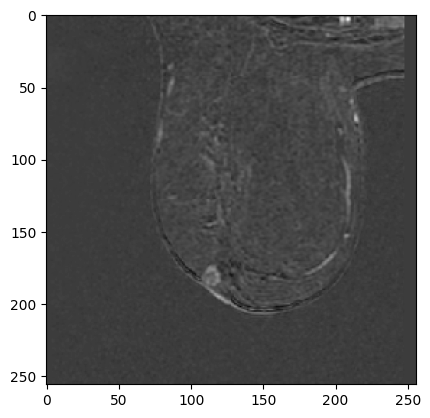

In [6]:
i = datasets[patient_id[0]]['patches_sub_test_ds'][104][0]['image']

plt.imshow(np.squeeze(i), cmap='gray')

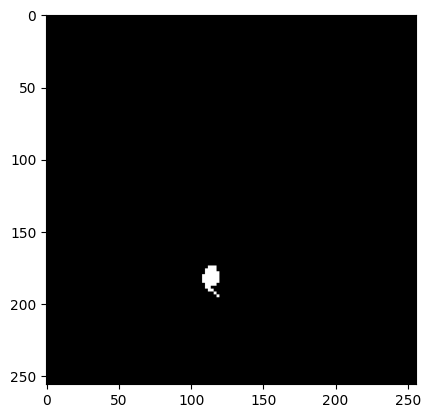

In [7]:
i = datasets[patient_id[0]]['patches_sub_test_ds'][104][0]['label']

plt.imshow(np.squeeze(i), cmap='gray')

## Model Checkpoint Paths


In [8]:
model_paths = {
    # VENUS fusion models
    'venus_large': f'{CHECKPOINTS_DIR}/venus-large-best.ckpt',
    
    # Baseline models
    'unetplusplus': f'{CHECKPOINTS_DIR}/unetplusplus_model.ckpt',
    'skinny': f'{CHECKPOINTS_DIR}/skinny_model.ckpt',
    'resnet50': f'{CHECKPOINTS_DIR}/resnet50-model.ckpt',
    'fcn': f'{CHECKPOINTS_DIR}/unetplusplus_model.ckpt',  
    'segnet': f'{CHECKPOINTS_DIR}/segnet_model_large.ckpt',
    'swin': f'{CHECKPOINTS_DIR}/swin_model.ckpt',
    
    # Patches models
    'resnet18-patches':  f'{CHECKPOINTS_DIR}/resnet18-patches-model.ckpt'
}

# Check which models are available
print("Available models:")
for name, path in model_paths.items():
    if os.path.exists(path):
        print(f"  ✓ {name}: {path}")
    else:
        print(f"  ✗ {name}: {path} (not found)")


Available models:
  ✓ venus_large: ./checkpoints/private-dataset/venus-large-best.ckpt
  ✓ unetplusplus: ./checkpoints/private-dataset/unetplusplus_model.ckpt
  ✓ skinny: ./checkpoints/private-dataset/skinny_model.ckpt
  ✓ resnet50: ./checkpoints/private-dataset/resnet50-model.ckpt
  ✓ fcn: ./checkpoints/private-dataset/unetplusplus_model.ckpt
  ✓ segnet: ./checkpoints/private-dataset/segnet_model_large.ckpt
  ✓ swin: ./checkpoints/private-dataset/swin_model.ckpt
  ✓ resnet18-patches: ./checkpoints/private-dataset/resnet18-patches-model.ckpt


## Test Baseline Models


In [ ]:
# Test baseline models (6 tests)
baseline_tests = [
    ('unetplusplus', 'UNet++', 'unetplusplus'),
    ('skinny', 'SkinnyNet', 'skinny') ,
    ('fcn', 'FCN', 'unetplusplus'), 
    ('segnet', 'SegNet', 'segnet'),
    ('swin', 'Swin-UNETR', 'swin_unetr'),
    ('resnet50', 'ResNet50', 'resnet50')
]

baseline_results = {}
for model_key, model_name, arch_name in baseline_tests:
    if os.path.exists(model_paths[model_key]):
        print(f"Testing {model_name} model...")
        result = test_dataset_aware_no_patches(
            model_path=model_paths[model_key],
            patient_ids=x_test,
            datasets=datasets,
            dataset_key="no_thorax_sub_test_ds",
            filter=False,
            get_scores_for_statistics=False,
            get_only_masses=False,
            arch_name=arch_name,
            strict=True,
            subtracted=True
        )
        baseline_results[model_key] = result
        print(f"\n{model_name} Results:")
        pp.pprint(result)
    else:
        print(f"{model_paths[model_key]} not found.")
        baseline_results[model_key] = None

print(f"\nCompleted {len([r for r in baseline_results.values() if r is not None])} baseline model tests.")


## Test VENUS Model


In [ ]:
# Test 1: venus-large-best.ckpt
if os.path.exists(os.path.join(CHECKPOINTS_DIR,"PRIVATE-FUSION-SUB-CABL-NO-DECODER-ATTENTION-FINAL.ckpt")): 
    print("Testing VENUS Large ...")
    scores_for_statistics_fusion_large2 = test_dataset_aware_fusion(
        model_path=os.path.join(CHECKPOINTS_DIR,"PRIVATE-FUSION-SUB-CABL-NO-FUSION-FINAL.ckpt"),
        patient_ids=x_test,
        datasets=datasets,
        whole_dataset_key="no_thorax_sub_test_ds",
        patches_dataset_key="patches_sub_test_ds",
        use_simple_fusion=True,
        use_decoder_attention=True,
        strict=True,
        filter=False,
        subtracted=True,
        get_scores_for_statistics=False,
        get_only_masses=False,
        base_channels=64
    )
    print("\nVENUS Large:")
    pp.pprint(scores_for_statistics_fusion_large2)
else:
    print("venus-large.ckpt not found.")
    scores_for_statistics_fusion_large2 = None

c:\Users\pabli\AppData\Local\pypoetry\Cache\virtualenvs\venus-nCPuPPcI-py3.9\lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 't_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['t_loss'])`.


Testing VENUS Large ...
AA1604


100%|██████████| 228/228 [00:06<00:00, 32.98it/s] 


MODEL CLASS MEAN IOU  0.49970418
MODEL CLASS STD IOU  0.00018069387

MODEL CLASS MEAN DICE  0.49985197
MODEL CLASS STD DICE  9.042815e-05

MODEL DIOU 0.0
MODEL DIOU STD  0.0

MODEL IOU MASS VOLUME  0.8201754093170166
MODEL IOU MASS VOLUME STD  0.384886234998703

MODEL IOU MASS VOLUME NO EMPTY  0.0
MODEL IOU MASS VOLUME NO EMPTY STD  0.0

MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC  0.0
MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD  0.0
MODEL DICE MASS VOLUME  0.8201754093170166
MODEL DICE MASS VOLUME STD  0.38404127955436707

MODEL DICE MASS VOLUME NO EMPTY  0.0
MODEL DICE MASS VOLUME NO EMPTY STD  0.0

MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC  0.0
MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD  0.0

MODEL MEAN ACCURACY NO EMPTY 0.49994680285453796
MODEL MEAN ACCURACY NO EMPTY STD 0.00013704010052606463

MODEL MEAN PRECISION NO EMPTY nan
MODEL MEAN PRECISION NO EMPTY STD nan

MODEL MEAN RECALL NO EMPTY 0.5
MODEL MEAN RECALL NO EMPTY STD 0.0

MODEL MEAN F1 NO EMPTY 0.49985203
MODEL MEAN

c:\Users\pabli\AppData\Local\pypoetry\Cache\virtualenvs\venus-nCPuPPcI-py3.9\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


: 

## Test Ensemble Model


In [ ]:
ensemble_tests = [

    ('venus_large', 'resnet18-patches', False, 64, 'VENUS Large + ResNet18 patches'),
    ('venus_large', 'resnet18-patches', True, 64, 'VENUS Large + ResNet18 patches (filtered)'),
]


ensemble_results = {}
for whole_key, patches_key, use_filter, base_channels, description in ensemble_tests:
    if os.path.exists(model_paths[whole_key]) and os.path.exists(model_paths[patches_key]):
        print(f"Testing Ensemble: {description}...")
        
        result = test_dataset_aware_ensemble(
            model_whole_path=model_paths[whole_key],
            model_patches_path=model_paths[patches_key],
            patient_ids=x_test,
            datasets=datasets,
            whole_dataset_key="no_thorax_sub_test_ds",
            patches_dataset_key="patches_sub_test_ds",
            filter=use_filter,
            get_scores_for_statistics=False,
            get_only_masses=False,
            subtracted=True,
            base_channels=base_channels
        )
        
        ensemble_key = f"{whole_key}+{patches_key}{'_filtered' if use_filter else ''}"
        ensemble_results[ensemble_key] = result
        print(f"\n{description} Results:")
        pp.pprint(result)
    else:
        print(f"Required models not found for ensemble: {description}")
        ensemble_key = f"{whole_key}+{patches_key}{'_filtered' if use_filter else ''}"
        ensemble_results[ensemble_key] = None

print(f"\nCompleted {len([r for r in ensemble_results.values() if r is not None])} ensemble model tests.")
